In [10]:
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from numpy.random import seed
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook
import pandas_datareader.data as pdr

import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [6]:
def get_market_data(market, tag=True):
    """
    market: the full name of the cryptocurrency as spelled on coinmarketcap.com. eg.: 'bitcoin'
    tag: eg.: 'btc', if provided it will add a tag to the name of every column.
    returns: panda DataFrame
    This function will use the coinmarketcap.com url for provided coin/token page. 
    Reads the OHLCV and Market Cap.
    Converts the date format to be readable. 
    Makes sure that the data is consistant by converting non_numeric values to a number very close to 0.
    And finally tags each columns if provided.
    """
    now = datetime.now()
    market_data = pd.read_html("https://coinmarketcap.com/currencies/" + market + 
                             "/historical-data/?start=20130428&end="+now.strftime("%Y%m%d"), flavor='html5lib')[0]
    market_data = market_data.assign(Date=pd.to_datetime(market_data['Date']))  
    market_data['Volume'] = (pd.to_numeric(market_data['Volume'], errors='coerce').fillna(0))
    if tag:
        market_data.columns = [market_data.columns[0]] + [tag + '_' + i for i in market_data.columns[1:]]
    return market_data

In [32]:
#Setting the end date to today
end = datetime.today()

#Start date set to one year back
start = datetime(end.year-8,end.month,end.day)
#using yahoo finance to grab cryptocurrency data

BTC = pdr.DataReader('BTC-USD','yahoo',start,end)
ETH = pdr.DataReader('ETH-USD','yahoo',start,end)
LTC = pdr.DataReader('LTC-USD','yahoo',start,end)

print(BTC.tail())
# print(ETH.head())
# print(LTC.head())

                   High          Low         Open        Close       Volume  \
Date                                                                          
2019-11-17  8727.789062  8500.967773  8549.470703  8577.975586  18668638896   
2019-11-18  8653.280273  8273.573242  8573.980469  8309.286133  21579470673   
2019-11-19  8408.516602  8099.963379  8305.134766  8206.145508  21083613815   
2019-11-20  8237.240234  8010.511719  8203.613281  8027.268066  20764300436   
2019-11-21  8109.221191  7599.635742  8018.209473  7645.630371  22280812544   

              Adj Close  
Date                     
2019-11-17  8577.975586  
2019-11-18  8309.286133  
2019-11-19  8206.145508  
2019-11-20  8027.268066  
2019-11-21  7645.630371  


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


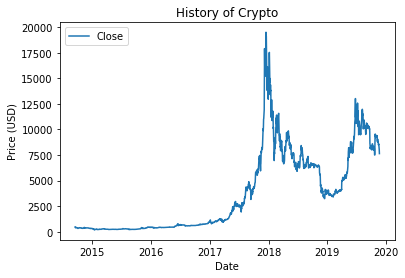

In [16]:
plt.figure()
plt.plot(BTC.index, BTC["Adj Close"])
plt.title('History of Crypto')
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.legend(['Close'], loc='upper left')
plt.show()

In [23]:
#Features
train_cols = ['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']
#Make training set 80% of the data
btc_train, btc_test = train_test_split(BTC, train_size=0.8, test_size=0.2, shuffle=False)
x = btc_train.loc[:,train_cols].values
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x)
x_test = scaler.fit_transform(BTC.loc[:,train_cols])

In [24]:
#How many days in the past that we want to look at
TIME_STEPS = 5

def build_timeseries(mat, y_col_index):
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS + i]
        y[i] = mat[TIME_STEPS + i, y_col_index]
    print("Length of time-series i/o", x.shape, y.shape)
    return x, y

def trim_data(mat, batch_size):
    num_rows_dropped = mat.shape[0]%batch_size
    if(num_rows_dropped > 0):
        return mat[:-num_rows_dropped]
    else:
        return mat

In [25]:
BATCH_SIZE = 2

x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_data(x_t, BATCH_SIZE)
y_t = trim_data(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_data(x_temp, BATCH_SIZE), 2)
y_val, y_test_t = np.split(trim_data(y_temp, BATCH_SIZE), 2)
print(x_test_t.shape)


Length of time-series i/o (1508, 5, 6) (1508,)



Length of time-series i/o (1887, 5, 6) (1887,)
(943, 5, 6)


In [26]:
model = Sequential()
model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0,
              recurrent_dropout=0.0, stateful=True, kernel_initializer='random_uniform'))
model.add(Dropout(0.5))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='adam') 
model.summary()

btc_history = model.fit(x_t, y_t, epochs=10, verbose=2, 
                        batch_size=BATCH_SIZE, shuffle=False, 
                        validation_data=(trim_data(x_val, BATCH_SIZE), trim_data(y_val, BATCH_SIZE)))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (2, 100)                  42800     
_________________________________________________________________
dropout_1 (Dropout)          (2, 100)                  0         
_________________________________________________________________
dense_1 (Dense)              (2, 20)                   2020      
_________________________________________________________________
dense_2 (Dense)              (2, 1)                    21        
Total params: 44,841
Trainable params: 44,841
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 1508 samples, validate o

In [27]:
y_pred = model.predict(trim_data(x_test_t, BATCH_SIZE), batch_size= BATCH_SIZE)
print(x_test_t.shape)
y_pred - y_pred.flatten()
y_test_t = trim_data(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is ", error, y_pred.shape, y_test_t.shape)

(943, 5, 6)
Error is  0.03151622042435691 (942, 1) (942,)


In [28]:
#3 being the amount of y_cols
y_pred_org = (y_pred * scaler.data_range_[3] + scaler.data_min_[3])
y_test_org_t = (y_test_t * scaler.data_range_[3] + scaler.data_min_[3])

print(y_pred_org.shape)
print(y_test_org_t.shape)

(942, 1)
(942,)


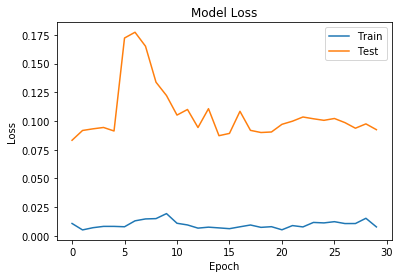

In [29]:
plt.figure()
plt.plot(btc_history.history['loss'])
plt.plot(btc_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])

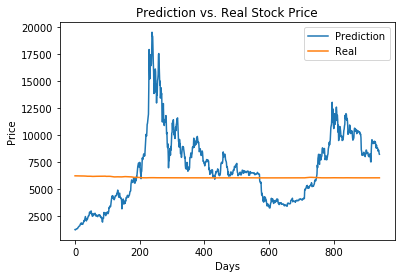

In [31]:
plt.figure()
plt.plot(y_test_org_t)
plt.plot(y_pred_org)

plt.title('Prediction vs. Real Stock Price')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend(['Prediction', 'Real'])
ax = plt.gca()
plt.show()